# KL Dra

In [18]:
import json
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.lightcurve import LightCurve as LC
from lightkurve import TessTargetPixelFile

import eleanor

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
output_notebook()


Loading BokehJS ...

In [2]:
with open('response.json','r') as JSON:
    rdic = json.load(JSON)
kldra = rdic['KL Dra']

In [3]:
kldra['ra']
kldracoord = "{} +{}".format(kldra['ra'],kldra['dec'])
print(kldracoord)

291.1595 +59.696305555555554


In [4]:
lk.search_tesscut(kldracoord)

#,observation,target_name,productFilename,distance
0,TESS Sector 14,291.1595 +59.696305555555554,TESSCut,0.0
1,TESS Sector 15,291.1595 +59.696305555555554,TESSCut,0.0
2,TESS Sector 16,291.1595 +59.696305555555554,TESSCut,0.0
3,TESS Sector 17,291.1595 +59.696305555555554,TESSCut,0.0


In [5]:
tpf = lk.search_tesscut(kldracoord,sector=14).download(cutout_size=11)

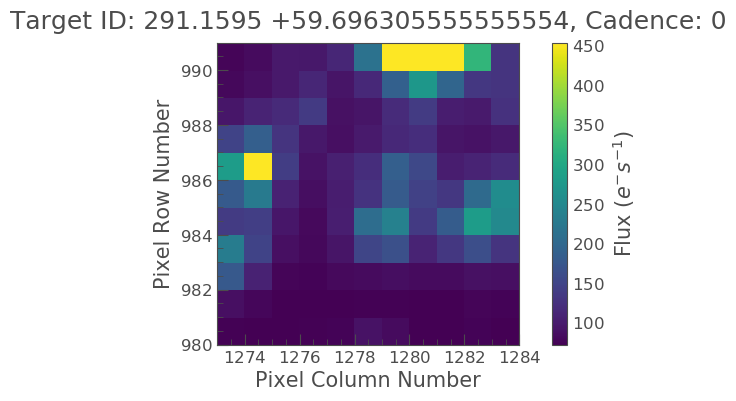

In [6]:
tpf.plot()

# Define the aperture and plot it

3


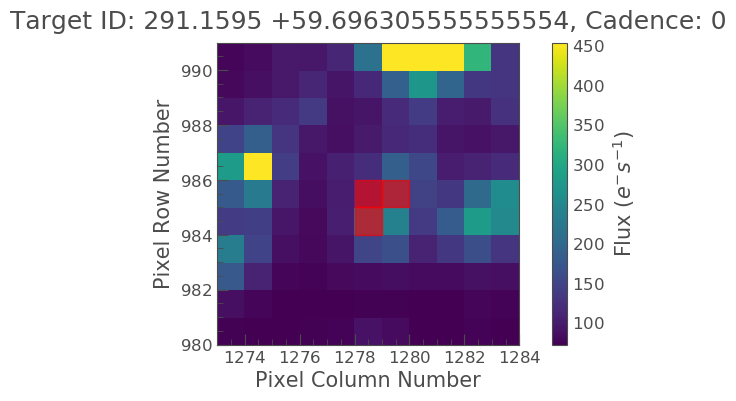

In [7]:
aper = np.zeros(tpf.shape[1:], dtype=np.int)
#aper[5:6, 5:6] = 1 #
aper[4:6, 5] = 1
aper[5, 6] = 1 #y luego x


tpf.plot(aperture_mask=aper, mask_color='red');
n_target_pixels = aper.sum()
print(n_target_pixels)

## Create a light-curve

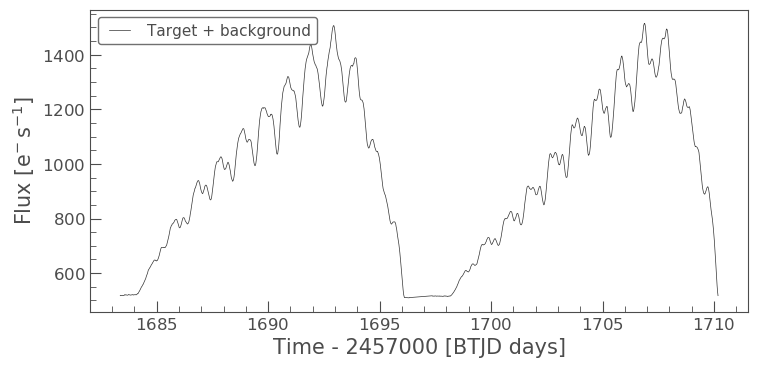

In [8]:
target_lc = tpf.to_lightcurve(aperture_mask=aper.astype(bool))
target_lc.plot(label='Target + background');

61


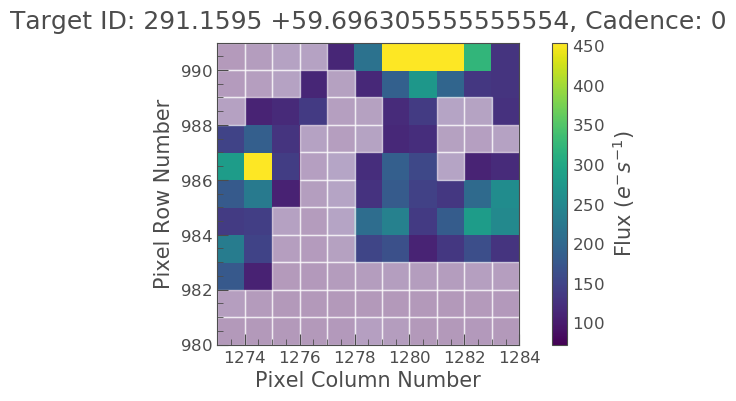

In [9]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0001, reference_pixel=None)
tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
print(n_background_pixels)

In [10]:
tpf.interact_sky()

In [11]:
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
background_estimate_lc = background_lc_per_pixel * n_target_pixels

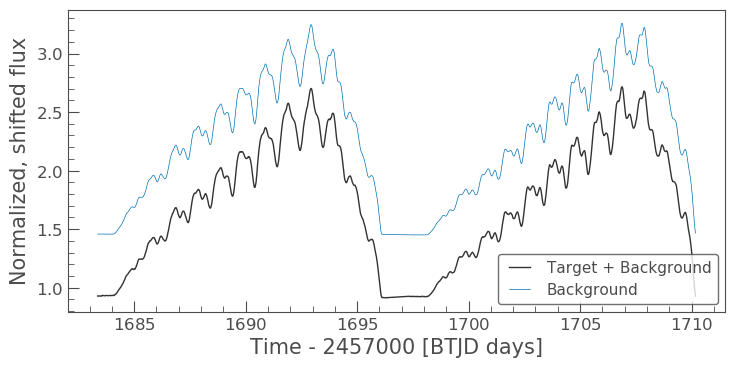

In [12]:


common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');



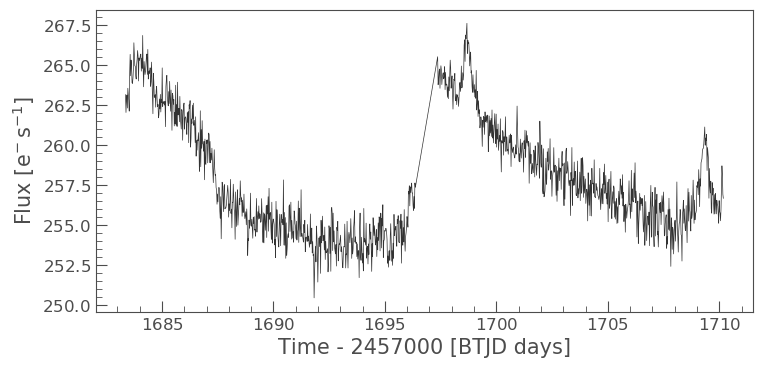

In [13]:
corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot();

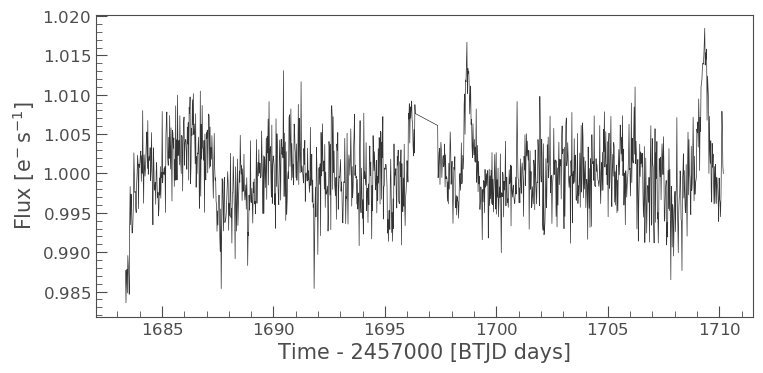

In [14]:
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot();



In [15]:
lcdic = {'time':flat_lc.time,
        "flatflux":flat_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500)
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

In [16]:
corrected_lc.flux.flatten()

array([263.15125, 262.03772, 262.84192, ..., 258.15262, 256.91605,
       256.66873], dtype=float32)

# Sector 14 with Eleanor

In [19]:
star = eleanor.Source(coords=(kldra['ra'],kldra['dec']), sector=14, tc=True)
data = eleanor.TargetData(star,height=11, width=11)

/home/mmarcano/anaconda3/envs/ele/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/ele/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


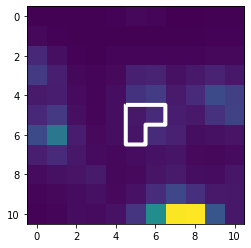

In [20]:
vis = eleanor.Visualize(data)
vis.aperture_contour()

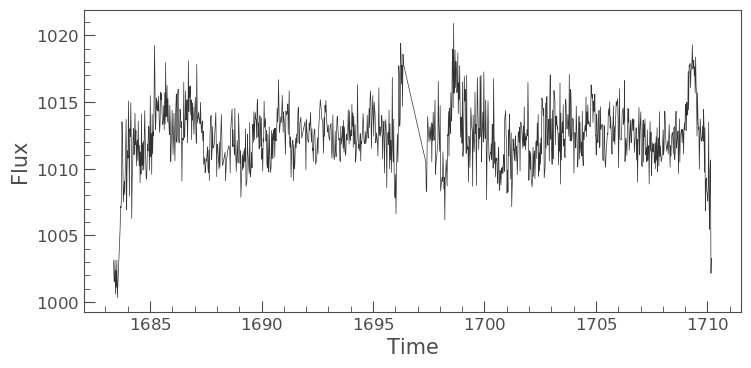

In [21]:
q = data.quality == 0
lk = LC(data.time[q], data.corr_flux[q]).plot()